## Execute before Propagation/Analysis

In [1]:
%matplotlib notebook
# For importing event data
import sys 
sys.path.append("/Users/Hilary/Documents/Github/Py-NnK/scan")
sys.path.append("/Users/Hilary/Documents/Data/DataIceland")
import obspy
import EQ
from obspy import read
# Convert degree to distance
from obspy.geodetics.base import calc_vincenty_inverse
#import glob, os

# For velocity model fitting
from scipy.optimize import curve_fit
def e_fit(x, a, b, c):
    return a * np.exp(-b * x) +c

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read a single event (with all the 18 stations)
stm = read("/Users/Hilary/Documents/Github/Data/DataIceland/20101221012407/*.sac")
# Event(source) location
ev_loc=EQ.single_ev_loc(stm)
evla=ev_loc[0]
evlo=ev_loc[1]
evdp=ev_loc[2]
# Station location 
st_loc=EQ.st_loc(stm)  
st_dis_in_m=[]              
for i in range(len(stm)//3):   # Convert distance between stations and source from degrees to meters
    st_name = st_loc[2][i]
    distance= calc_vincenty_inverse(st_loc[0][i], st_loc[1][i], ev_loc[0], ev_loc[1])[0]
    st_dis_in_m.append([st_name, distance])

In [3]:
# A simple 2D finite difference solver modified from Computational Seismology by Heiner Igel ######
# The original code can be aqcuired at: http://www.seismo-live.org ################################

nx = 1000     # Number of grid points in x  
nza = 1       # Number of grid points in z(boundary-air)
nzg = 500     # Number of grid points in z(ground)
nz = nza+nzg  # Number of grid points in z(total)
nt = 1900     # Number of time steps
dx = 100.0    # Grid intervel in x (unit: m)
dt = 0.005    # Time step
ca = 340      # P Velocity in air layer
f0 = 5.0      # Frequency of source (unit: Hz)
isx = nx//2   # Source index x  
isz = nza     # Source index z
ist = 4./f0   # Shifting of source time function so the full waveform is presented
isnap = 10    # Snapshot frequency
T = 1.0 / f0  # Period of source
nop = 3       # Length of operator (option: 3 or 5 step scheme) 
              # Depending on the fd scheme, there is no value at boundaries;
              # hence the introducing of the air layer
              # If nop=3, need to set nza>=1. If nop=5, need to set nza>=2.

## Velocity Model

In [4]:
# Get parameters by fitting model data in Tryggvason et al 2002 #############################
# Tryggvason et al 2002 data
model_dep = np.array([  0,   2,   4,   6,   9,  12,  16,  21,  32])
model_vel = np.array([3.6, 5.6, 6.4, 6.6, 6.7, 6.8, 7.0, 7.1, 7.4])
# Exponential fit between 0~4km depth
Z1, pcov = curve_fit(e_fit, model_dep[0:4], model_vel[0:4])
# Linear fit below 6km depth 
Z3 = np.polyfit(model_dep[3:], model_vel[3:], 1)

In [5]:
# Select model type ##############################################################
# (Options: homogeneous/increase linearly with depth/Tryggvason et al 2002)
model_type = "Tryggvason et al 2002"  

# Initialize velocity model
c = np.zeros((nz, nx))
for i in range(0, nza):
    c[i,:] += ca    
for i in range(0,44):                   #   0 ~ 4.3km: (Zone1) P velocity increases exponentially
    c[nza+i,:] = 1000* (Z1[0] * np.exp(-Z1[1] * i*dx/1000) +Z1[2])
for i in range(44, 60):                 # 4.4 ~ 5.9km: (Zone2) interpolation between Zone 1&2 
    dp=model_dep[2:4]                   # Note: 4.4km: v=6440m/s
    vp=model_vel[2:4]
    c[nza+i,:] = 1000* np.interp(i*dx/1000, dp,vp)  
for i in range(60, nzg):                # 6.0 ~bottom: (Zone3) linear increase 
                                        # (get param 6590 by observation of data)
    c[nza+i,:] = 1000* (Z3[0]*(i-59)*dx/1000+ 6.590) # Get param 6590 by observation

    
    
# Courant Criterion eps (stability)
cmax = c.max()      
print("Courant Criterion eps :")
print(cmax*dt/dx)

Courant Criterion eps :
0.397571748878924


<IPython.core.display.Javascript object>


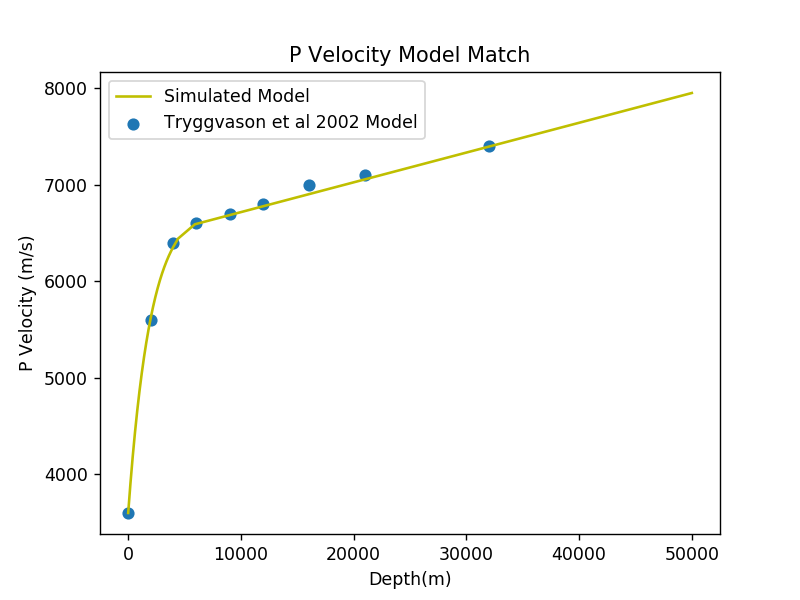

<IPython.core.display.Javascript object>


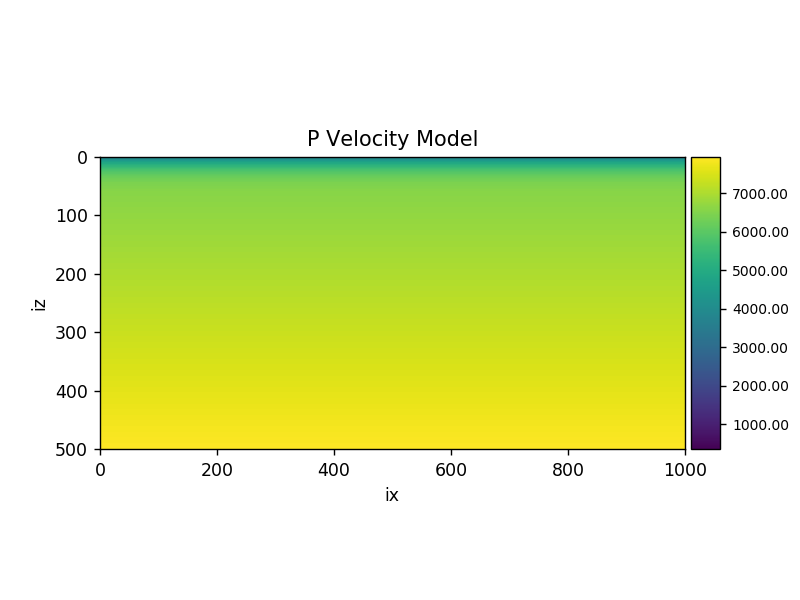

In [9]:
# Check how fit my velocity model is with Tryggvason et al 2002 Model
fig, ax = plt.subplots()
# Plot the Tryggvason et al 2002 Model as scatter points
x1=np.linspace(0,nzg*dx,nzg)
plt.scatter(1000*model_dep, 1000*model_vel,label='Tryggvason et al 2002 Model')
# Plot the simulated model 
plt.plot(x1, c[nza:,0], '-',color='y',label='Simulated Model')

plt.title('P Velocity Model Match')
plt.xlabel('Depth(m)')
plt.ylabel('P Velocity (m/s)')
plt.legend()
plt.show()

# Visualizing the velocity model
fig, ax = plt.subplots()
plt.title('P Velocity Model')
plt.imshow(c)
plt.xlabel('ix')
plt.ylabel('iz')
# Set colorbar to have the same height of the subplot
ax_divider 	= make_axes_locatable(ax)
cax			= ax_divider.append_axes("right", size= "5%", pad= 0.05)
cbar		= plt.colorbar(cax= cax, format='%.2f')
cbar.ax.tick_params(labelsize= 8)

plt.show()

## Source Time Function

<IPython.core.display.Javascript object>


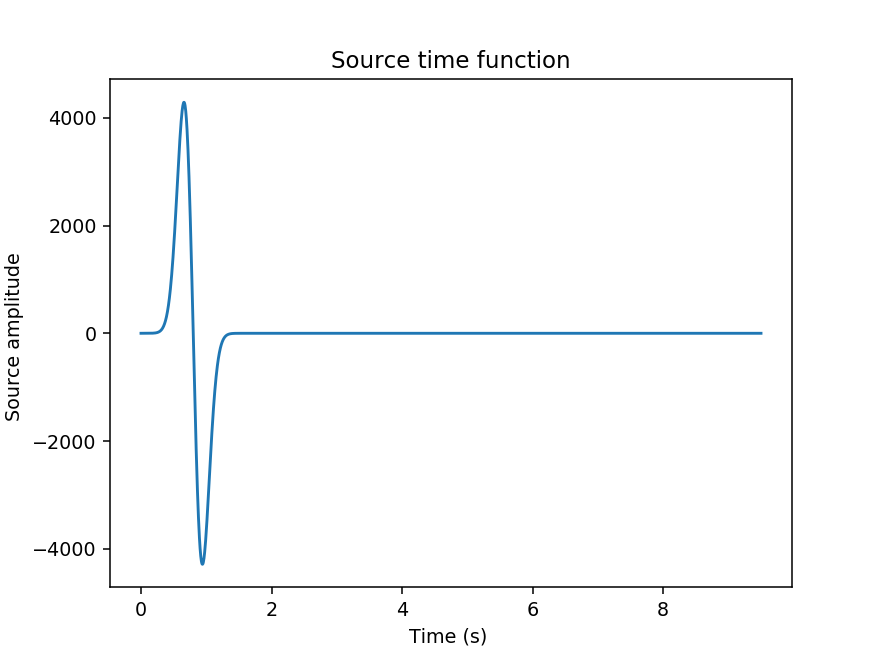

Text(0,0.5,'Source amplitude ')

In [17]:
# Source time function Gaussian, nt + 1 as we loose the last one by diff
src = np.empty(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
src  = -2000. * (time - ist) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - ist) ** 2))
# Plot the source time function
fig, ax = plt.subplots()
plt.plot(time, src)
plt.title('Source time function')
plt.xlabel('Time (s) ')
plt.ylabel('Source amplitude ')

## Receivers Grid Setup

In [10]:
# Setup Receiver Grid ######################################################
drz=10                      # Receiver grid interval (unit=100m)
drx=10                      # Receiver grid interval (unit=100m)
max_rz= 200                 # The maximum z-depth of recivers grid 
nrz = (max_rz//drz)         # Number of receivers in z-direction
max_rx = 450                # The maximum x-distance of recivers grid
nrx = (max_rx//drx)         # Number of reiceivers in x-direction

# Assign FD grid z-coordinates to the receivers
irz= np.zeros((nrz, nrx))  
for i in range(nrz):
    irz[i,:]=int( isz  +  i*drz )

# Assign FD grid x-coordinates to the receivers
irx= np.zeros_like(irz)
for i in range(nrx):
    irx[:,i]=int( isx   +  i*drx )
# Convert to integer so irz and irx can be used as index
irz=irz.astype(int)
irx=irx.astype(int)

# Numbering receivers in x and z direction
ir_x_dir = np.arange(nrx) 
ir_z_dir = np.arange(nrz)

# Initualize seismogram
seis = np.zeros((nrz, nrx,nt))

# Initialize pressure at different time steps and the second ##############
# derivatives in each direction
p = np.zeros((nz, nx))
pold = np.zeros((nz, nx))
pnew = np.zeros((nz, nx))
pxx = np.zeros((nz, nx))
pzz = np.zeros((nz, nx))

## Finite Difference Scheme (and save result)

In [ ]:
# Initialize animated plot
fig, ax = plt.subplots(figsize=(10,8))
v = max([np.abs(src.min()), np.abs(src.max())])
image = plt.imshow(pnew, interpolation='nearest', animated=True,
                   vmin=-v, vmax=+v, cmap=plt.cm.RdBu)

# Plot the receivers
for z in irz[:,0]:
    for x in irx[0,:]:
        plt.text(x, z, '.')

plt.text(isx, isz, 'o')
plt.hlines(y=nza,xmin=0,xmax=nx)
plt.colorbar()
plt.xlabel('ix')
plt.ylabel('iz')

plt.ion()
plt.show(block=False)

# Time extrapolation
for it in range(nt):
    if nop==3:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(1, nx - 1):
            pzz[:, i] = p[:, i + 1] - 2 * p[:, i] + p[:, i - 1]
        for j in range(1, nz - 1):
            pxx[j, :] = p[j - 1, :] - 2 * p[j, :] + p[j + 1, :]

    if nop==5:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(2, nx - 2):
            pzz[:, i] = -1./12*p[:,i+2]+4./3*p[:,i+1]-5./2*p[:,i]+4./3*p[:,i-1]-1./12*p[:,i-2]
        for j in range(2, nz - 2):
            pxx[j, :] = -1./12*p[j+2,:]+4./3*p[j+1,:]-5./2*p[j,:]+4./3*p[j-1,:]-1./12*p[j-2,:]
                            
    pxx /= dx ** 2
    pzz /= dx ** 2

    # Time extrapolation
    pnew = 2 * p - pold + dt ** 2 * c ** 2 * (pxx + pzz)
    # Add source term at isx, isz
    pnew[isz, isx] = pnew[isz, isx] + src[it]

    # Plot every isnap-th iteration
    if it % isnap == 0:    # you can change the speed of the plot by increasing the plotting interval
        
        plt.title("t={0:}, max P: {1:.2f}".format(it,p.max()))
        image.set_data(pnew)
        plt.gcf().canvas.draw()

    pold, p = p, pnew

    # Save seismograms
    for x in ir_x_dir:
        for z in ir_z_dir:
            seis[z, x, it] = p[irz[z,0], irx[0,x]]

In [13]:
# Save data to file
np.save('save/FD_seismograms_f0{}_dt{}_dx{}_nop{}'.format(f0,dt,dx,nop), seis)

## Data Analysis

In [15]:
# Load data from file
data= np.load('save/FD_seismograms_f0{}_dt{}_dx{}_nop{}.npy'.format(f0,dt,dx,nop))

<IPython.core.display.Javascript object>


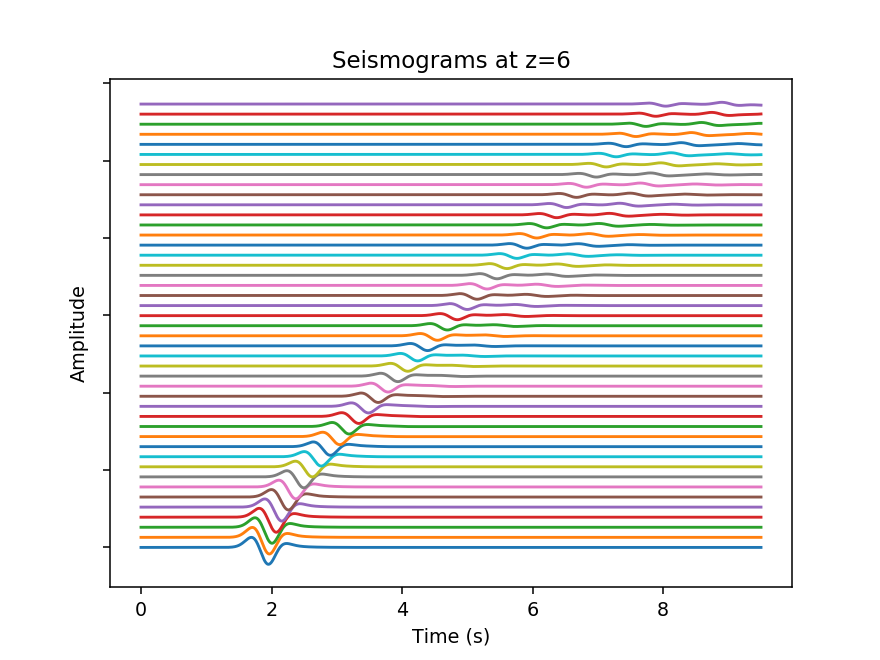

[]

In [18]:
# Plot the seismograms along certain depth #########################################################
z=6 # km

fig, ax = plt.subplots()
# For determining the verticle seperation in the graph
ymax = data[z,:,:].ravel().max() 

ir_x_dir = np.arange(len(data[z]))
ir_z_dir = np.arange(len(data)) 
for x in ir_x_dir:
    # Line seimograms up with verticle seperation= ymax
    y= data[z, x, :]  + ymax *x 
    plt.plot(time, y )
    
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Seismograms at z={}'.format(z))
ax.set_yticklabels([])  # Disable y-axis label

## Arrival Time Picking

In [ ]:
# Pick arrival time from the seismograms ################################################
# Initialize travel time array
t_fd = np.empty(shape=(nrz,nrx))
for z in ir_z_dir: 
    for x in ir_x_dir:
        fst_diff = np.diff(data[z,x])
        snd_diff = np.diff(fst_diff)
        # Arrivel nt = the 1st occurence of: "1st differential <0 and 2nd differential >0"
        nt=np.where((fst_diff[1:]<0) & (snd_diff>0))[0][0]
        # Convert "numbers of time unit" to "seconds"
        t_fd[z,x] = nt*dt-ist
print(fst_diff)

In [ ]:
t_fd[3,10]

In [ ]:
len(ir_x_dir)

In [20]:
# Save data to file
np.save('save/Travel_Time_Model_2Dfd', t_fd)

In [ ]:
from TravelTime import *
# Get travel time from SAC attributes
t_sac=TravelTime_SAC(stm)

In [ ]:
# Checking plot for making sure the back propagation is giving **somewhat** similar result
# comparing to data in SAC attributes. ####################################################
# Plot x distance vs P arrival time
# Choose depth of receiver line and plot
z=5  # km

fig, ax = plt.subplots()
plt.plot(ir_x_dir[0:30], t_fd[z][0:30],'.-',label='Back-Propagation: z={}'.format(z))
# Plot travel time in SAC attributes for comparison
for i,j in enumerate(st_dis_in_m):
    xx=st_dis_in_m[i][1]/1000
    yy= t_sac[i]
    ax.scatter(xx,yy)
    ax.annotate(st_dis_in_m[i][0],(xx,yy),xytext=(-40,-5), textcoords='offset points')
    
plt.legend()
plt.xlabel('x Distance ({0:.0f}km)'.format(drx*dx/1000))
plt.ylabel('Travel Time (s)')
plt.title('Travel Time Curve with scattered sac data z=6.186')

f=5 shows a better match than f=2 with sac attributes to stations far away.

Concern: In this region, attenuation is expected to be significant (with abundant fluid).... Does reverse time modeling still hold? Can we still use the seismogram as boundary condition?

In [21]:
# Load data from file
TTModel= np.load('save/Travel_Time_Model_2Dfd.npy')

In [ ]:
fig, ax = plt.subplots()
plt.imshow(TTModel)
plt.title('Travel Time Model')
plt.xlabel('Distance(km)')
plt.ylabel('Depth(km)')
cbar =plt.colorbar()
cbar.set_label('sec')